# Code for Identifying Breakpoints

This notebook contains the analysis which corresponds to the figures in the chapter related to breakpoint analysis.

In [1]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [17]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

validation_tasks = json_object['val']

validation_tasks

['6150a2bd',
 'c8f0f002',
 '68b16354',
 'c9e6f938',
 '6fa7a44f',
 'ac0a08a4',
 '4258a5f9',
 '9ecd008a',
 '25ff71a9',
 '3af2c5a8',
 '67e8384a',
 '56ff96f3',
 'dc1df850',
 'ae4f1146',
 'aabf363d',
 'aedd82e4',
 '445eab21',
 '41e4d17e',
 'f5b8619d',
 '00d62c1b',
 '3906de3d',
 '8d5021e8',
 '0ca9ddb6',
 'd0f5fe59',
 'ba97ae07',
 'd9fac9be',
 'ded97339',
 'f8ff0b80',
 'dbc1a6ce',
 '496994bd',
 'fcb5c309',
 'ff805c23',
 '5c0a986e',
 '7f4411dc',
 '6d75e8bb',
 'e76a88a6',
 '8f2ea7aa',
 '137eaa0f',
 '6e82a1ae',
 'a5f85a15',
 '4be741c5',
 '681b3aeb',
 '3ac3eb23',
 '253bf280',
 '3428a4f5',
 'a9f96cdd',
 '1caeab9d',
 '3de23699',
 'bdad9b1f',
 '88a62173',
 'f8b3ba0a',
 '88a10436',
 '7e0986d6',
 'd4a91cb9',
 '913fb3ed',
 '3631a71a',
 '95990924',
 '93b581b8',
 '9edfc990',
 'a65b410d',
 'ef135b50',
 '6e19193c',
 'cbded52d',
 'ae3edfdc',
 '4612dd53',
 'e48d4e1a',
 '846bdb03',
 '2204b7a8',
 'e5062a87',
 '539a4f51',
 '91413438',
 'e8dc4411',
 'e40b9e2f',
 'd6ad076f',
 'b190f7f5',
 '6cdd2623',
 'f9012d9b',

## Code for Generating Sequence Level Probabilities

['6150a2bd', 'c8f0f002', '68b16354', 'c9e6f938', '6fa7a44f', 'ac0a08a4', '4258a5f9', '9ecd008a', '25ff71a9', '3af2c5a8', '67e8384a', '56ff96f3', 'dc1df850', 'ae4f1146', 'aabf363d', 'aedd82e4', '445eab21', '41e4d17e', 'f5b8619d', '00d62c1b', '3906de3d', '8d5021e8', '0ca9ddb6', 'd0f5fe59', 'ba97ae07', 'd9fac9be', 'ded97339', 'f8ff0b80', 'dbc1a6ce', '496994bd', 'fcb5c309', 'ff805c23', '5c0a986e', '7f4411dc', '6d75e8bb', 'e76a88a6', '8f2ea7aa', '137eaa0f', '6e82a1ae', 'a5f85a15', '4be741c5', '681b3aeb', '3ac3eb23', '253bf280', '3428a4f5', 'a9f96cdd', '1caeab9d', '3de23699', 'bdad9b1f', '88a62173', 'f8b3ba0a', '88a10436', '7e0986d6', 'd4a91cb9', '913fb3ed', '3631a71a', '95990924', '93b581b8', '9edfc990', 'a65b410d', 'ef135b50', '6e19193c', 'cbded52d', 'ae3edfdc', '4612dd53', 'e48d4e1a', '846bdb03', '2204b7a8', 'e5062a87', '539a4f51', '91413438', 'e8dc4411', 'e40b9e2f', 'd6ad076f', 'b190f7f5', '6cdd2623', 'f9012d9b', 'e21d9049', 'eb5a1d5d', '0a938d79', '82819916', 'a78176bb', '952a094c', '98

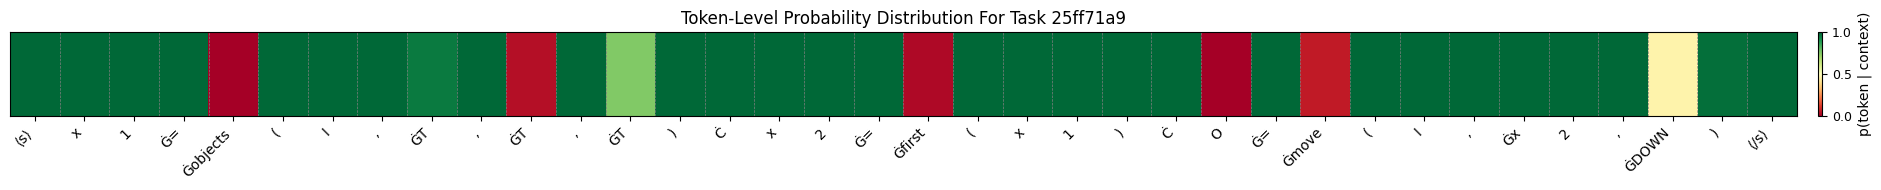

In [18]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task


def output_program_lines(task):
    print(f"=== Task {task.task_key} Program ===")

    print(task.program_lines)


def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    # teacher-forcing forward pass
    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
    
    log_p     = torch.log_softmax(logits, -1)

    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return tokens, p_token


 
def output_correct_token_probs(task_id, tokens, p_token): 
    fig, ax = plt.subplots(figsize=(len(tokens) * 0.6, 2))
    im = ax.imshow(np.array([p_token]), aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    ax.set_yticks([])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(display_tokens, rotation=45, ha="right", fontsize=10)
    
    ax.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    plt.title(f"Token-Level Probability Distribution For Task {task_id}")
    plt.tight_layout()
    plt.savefig('../figures/sequence-level-probs.png')
    plt.show()

def generate_task_level_analysis(task_id, model_path='../finetune/2025-05-27_17-42-37/checkpoint-1100'): 
    task = Task.from_json(f'../data/training/{task_id}.json')
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    output_program_lines(task)
    tokens, p_token = compute_logits(task, model)
    output_correct_token_probs(task.task_key, tokens, p_token)


print(validation_tasks)
# change here the task and model you wish to use.
task = validation_tasks[8]
generate_task_level_analysis(task, model_path='../finetune-checkpoint/dev-checkpoint')

## Code for Generating Correct Token Probability Across Dataset

In [7]:
def token_stats(logits, ids):
    log_p = torch.log_softmax(logits, -1)           # [1, L, V]
    probs = log_p.exp()

    entropy = -(probs * log_p).sum(-1).squeeze(0)   # [L]  (nats)

    # top-1 correctness
    top1_ids = logits.argmax(-1)                    # [1, L]
    is_correct = (top1_ids == ids).float().squeeze(0)

    p_true = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)

    return entropy.cpu(), is_correct.cpu(), p_true.cpu()


def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    entropy, is_correct, p_true = token_stats(logits, ids)

    
    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = tokenizer.convert_ids_to_tokens(ids[0])
    return tokens, p_token, entropy


def compute_correct_token_probs(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        _, p_token, _= compute_logits(task, model, tokenizer)

        token_probs.extend(p_token)
    
    return token_probs

def plot_correct_token_probs(correct_token_probs, filename):

    plt.figure(figsize=(8, 5))
    plt.hist(correct_token_probs, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)
    plt.title('Histogram of Probabilities Assigned to Correct Tokens')
    plt.xlabel('Probability Assigned to Correct Token')
    plt.ylabel('Number of Tokens')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename)

    plt.show()




### For Final Model

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


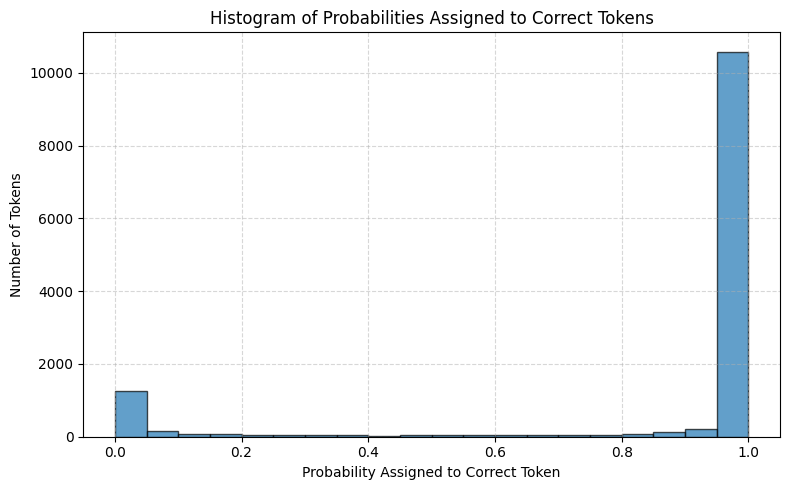

In [8]:

correct_token_probs = compute_correct_token_probs(validation_tasks,
                                                  '../finetune-checkpoint/dev-checkpoint')
plot_correct_token_probs(correct_token_probs, filename='../figures/main-model-histogram.png')

### For Different Stages of Training

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


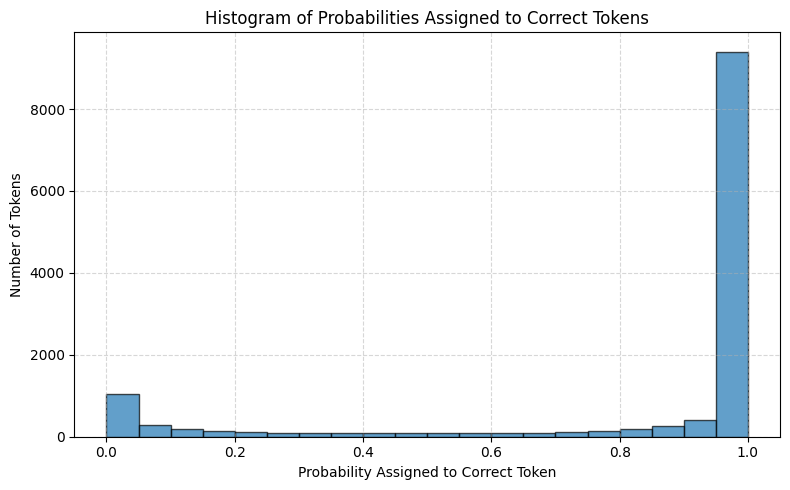

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


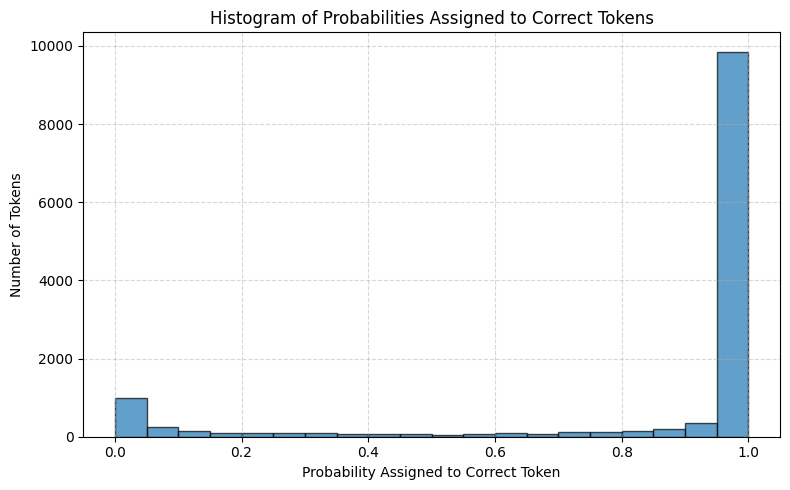

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


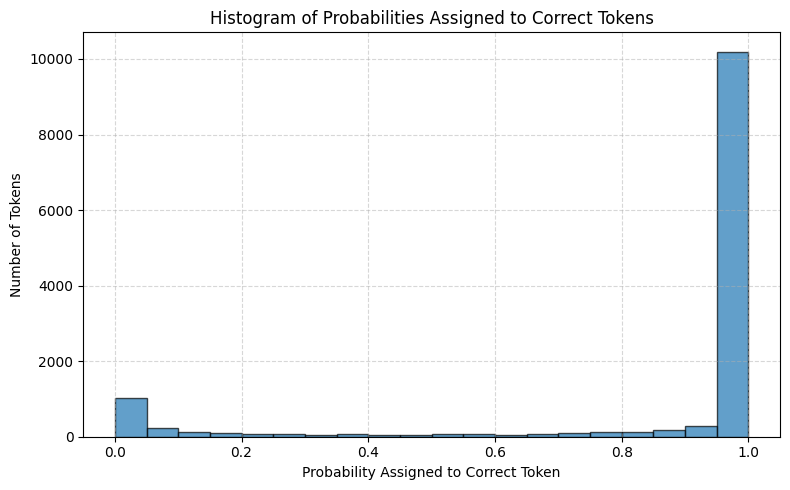

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


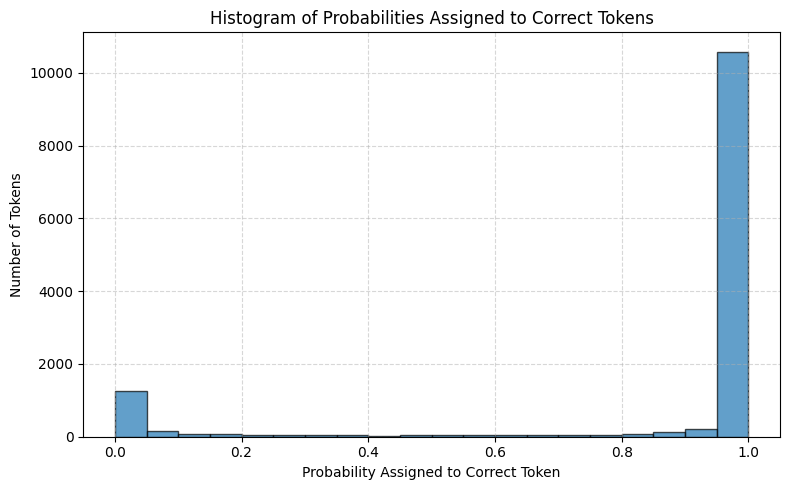

In [9]:
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-05-27_17-42-37/checkpoint-550'), '../figures/1-histogram.png')
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-05-27_17-42-37/checkpoint-1100'), '../figures/2-histogram.png')
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-05-27_17-42-37/checkpoint-1650'), '../figures/3-histogram.png')

plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune-checkpoint/dev-checkpoint'),'../figures/4-histogram.png')

## Code for Displaying Entropy-Relationship

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


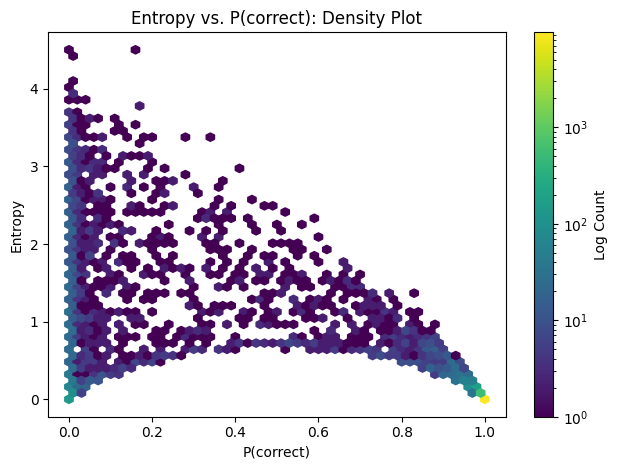

In [15]:

def compute_probs_and_entropies(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    entropies = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        _, p_token, entropy = compute_logits(task, model, tokenizer)

        token_probs.extend(p_token)
        entropies.extend(entropy)

    return np.array(token_probs), np.array(entropies)




def display_scatter_plot(correct_probs, entropies): 

    # Create mask for low-confidence predictions (P < 0.1)
    low_conf_mask = correct_probs < 0.1
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(correct_probs[low_conf_mask], entropies[low_conf_mask],
                color='red', alpha=0.6, label='P(correct) < 0.1')

    plt.scatter(correct_probs[~low_conf_mask], entropies[~low_conf_mask],
                color='blue', alpha=0.6, label='P(correct) > 0.1')

    plt.title('Entropy vs. Probability Assigned to Correct Token (Low-Confidence)')
    plt.xlabel('Probability Assigned to Correct Token')
    plt.ylabel('Entropy of Token Distribution')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()



def display_hex_bin(correct_probs, entropies):


    plt.hexbin(correct_probs, entropies, gridsize=50, cmap='viridis', bins='log')
    plt.colorbar(label='Log Count')
    plt.xlabel('P(correct)')
    plt.ylabel('Entropy')
    plt.title('Entropy vs. P(correct): Density Plot')
    plt.tight_layout()
    plt.savefig('../figures/entropy-hexbin.png')
    plt.show()


def display_violin_plots(correct_probs, entropies): 
   
    data = pd.DataFrame({
        'P_correct': correct_probs,
        'entropy': entropies
    })

    # Bin the P(correct) values
    data['bucket'] = pd.cut(data['P_correct'], bins=np.linspace(0, 1, 11), include_lowest=True)

    # Plot violin plot of entropy distributions per bucket
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='bucket', y='entropy', data=data, inner='quartile', scale='width')
    plt.title('Distribution of Entropy per P(correct) Bucket')
    plt.xlabel('P(correct) Bucket')
    plt.ylabel('Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


correct_probs, entropies = compute_probs_and_entropies(validation_tasks,  '../finetune-checkpoint/dev-checkpoint' )
display_hex_bin(correct_probs, entropies)

## Code for Plotting Token Types

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


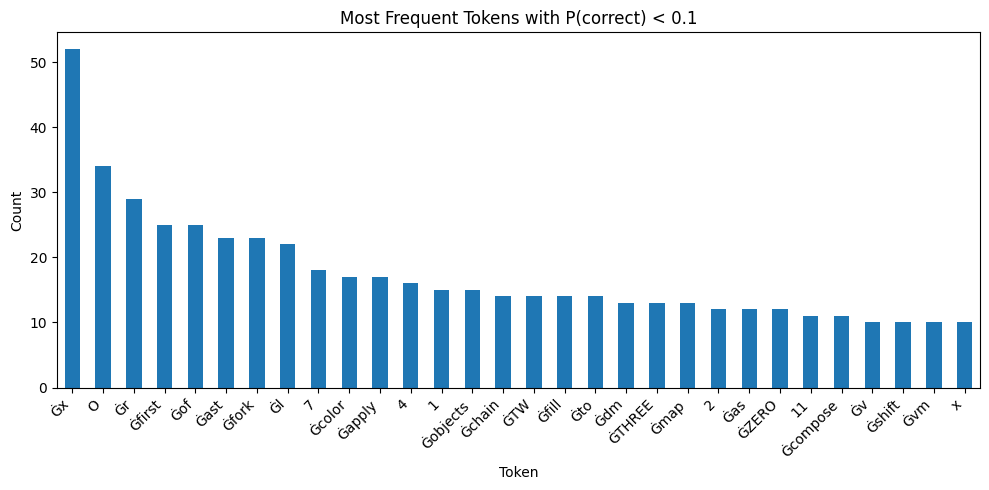

In [18]:

def compute_probs_and_token_ids(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    tokens = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        t, p_token, _= compute_logits(task, model, tokenizer)

        tokens.extend(t)
        token_probs.extend(p_token)
    
    return tokens, token_probs



def display_token_type_data(dataframe): 
    low_conf_df = df[df['p_correct'] < 0.1]

    token_counts = low_conf_df['token'].value_counts().head(30)

    plt.figure(figsize=(10, 5))
    token_counts.plot(kind='bar')
    plt.title('Most Frequent Tokens with P(correct) < 0.1')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../figures/low-prob-correct-tokens.png')
    plt.show()



tokens, token_probs = compute_probs_and_token_ids(validation_tasks, '../finetune/2025-05-27_17-42-37/checkpoint-1650' )

df = pd.DataFrame({
    'token': tokens,
    'p_correct': token_probs
})

display_token_type_data(df )

## Code for Plotting Overconfidently Wrong Tokens